# SMCN application for air quality predictions

In [1]:
import copy
import datetime
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

from smcl.smcl import SMCL
from src.utils import plot_range, uncertainty_estimation, LitProgressBar, boxplotprediction
from oze.utils import plot_predictions, plot_daily_predictions
from src.metrics import pi_metrics, compute_cost
from oze.dataset import OzeDataset

# Set manual seeds
torch.manual_seed(1)
np.random.seed(1)

# Reload python packages when changed
%load_ext autoreload
%autoreload 2

# Matplotlib defaults
plt.rcParams.update({
    "font.size": 25,
    "figure.figsize": (25, 5)
})

# PyTorch Lightning loading bar
bar = LitProgressBar()

In [2]:
# Dataset
PATH_DATASET = "datasets/data_oze.csv"
T = 24*7

# Model
D_EMB = 8
N = 200

# Training
BATCH_SIZE = 16
EPOCHS = 100
EPOCHS_SMCN = 100

## Dataset

### Load and preprocess

In [3]:
df = pd.read_csv(PATH_DATASET)[5*24:]
OzeDataset.preprocess(df)
df.sample(5)

/home/mrmojo/Code/these/smcl/oze/utils.py:60: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  occupancy = int(date < date_start_lockdown)
/home/mrmojo/Code/these/smcl/oze/utils.py:63: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_end_lockdown < date:


,TAMB,IGLOB_H,RHUM,IDIFF_H,IBEAM_H,IBEAM_N,GK,temperature_interieure,taux_co2,humidite,date,datetime,occupancy,val
8257,3.3,0.0,88.0,0.0,0.0,0.0,0.0,18.241022,418.645507,34.838398,1.607558e+09,2020-12-10 01:00:00,0.000000,False
5272,36.7,680.0,26.0,161.0,519.0,733.0,782.0,25.055576,494.292383,40.313563,1.596809e+09,2020-08-07 16:00:00,0.797734,False
11290,16.6,627.0,81.0,202.0,425.0,622.0,757.0,20.994866,515.028302,33.075831,1.618996e+09,2021-04-21 11:00:00,0.800000,True
1280,10.5,0.0,82.0,0.0,0.0,0.0,0.0,22.802724,411.924688,36.384693,1.582441e+09,2020-02-23 08:00:00,0.000000,False
11397,11.3,0.0,28.0,0.0,0.0,0.0,0.0,21.291948,396.680439,24.313181,1.619381e+09,2021-04-25 22:00:00,0.000000,True


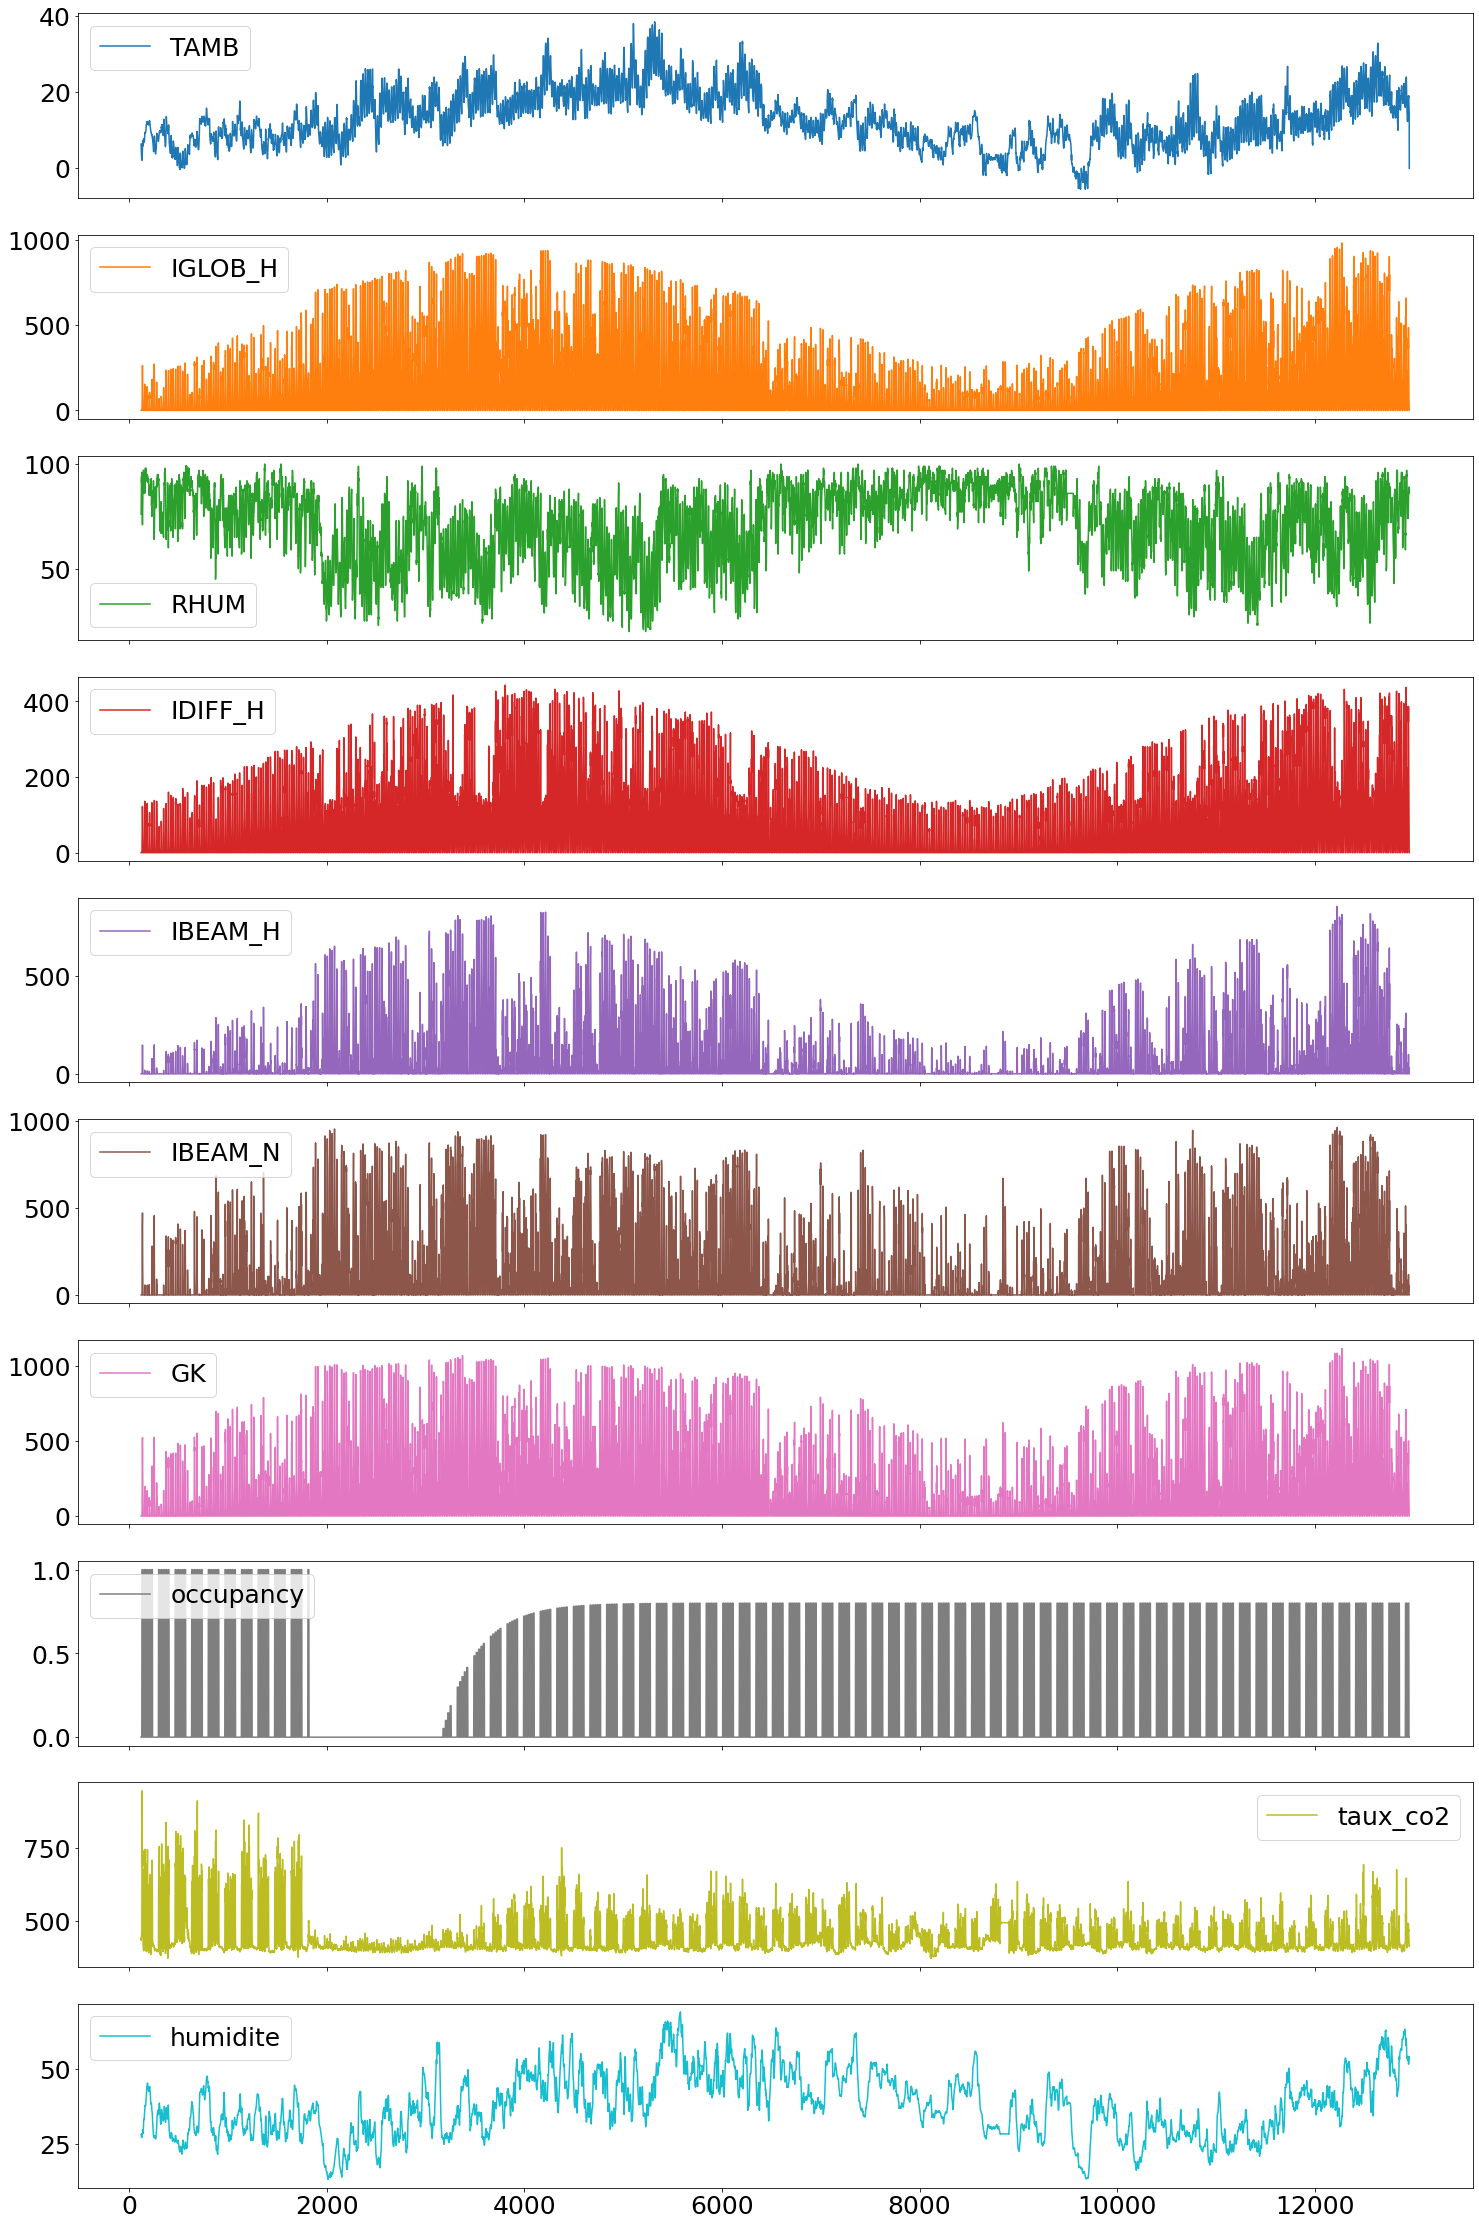

In [4]:
_ = df[[*OzeDataset.input_columns, *OzeDataset.target_columns]].plot(subplots=True, figsize=(25, 40))

### Define dataloaders

In [5]:
dataloader_train = DataLoader(
    OzeDataset(df, T=T, val=False),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

dataloader_val = DataLoader(
    OzeDataset(df, T=T, val=True),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

## Model

In [6]:
# We combine a generic input model (3 layered GRU) with a smc layer
class SMCM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.input_model = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=3)
        self.smcl = SMCL(input_size=hidden_size,
                         hidden_size=hidden_size,
                         output_size=output_size,
                         n_particles=100,
                        )
        
    def forward(self, u, y=None):
        u_tilde = self.input_model(u)[0]
        y_hat = self.smcl(u_tilde, y)
        return y_hat
    
    def uncertainty_estimation(self, u, y=None, p=0.05, observation_noise=True):
        u_tilde = self.input_model(u)[0]
        return self.smcl.uncertainty_estimation(u_tilde,
                                                  y=y,
                                                  p=p,
                                                  observation_noise=observation_noise)

In [7]:
D_IN = len(OzeDataset.input_columns)
D_OUT = len(OzeDataset.target_columns)

model = SMCM(input_size=D_IN, hidden_size=D_EMB, output_size=D_OUT)

## Traditional training

### Define training steps

In [8]:
class LitClassicModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criteria = torch.nn.MSELoss()
    
    def training_step(self, batch, batch_idx):
        u, y = batch
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)

        y_hat = self.model(u)
        loss = self.criteria(y, y_hat)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Train

In [9]:
train_model = LitClassicModule(model, lr=1e-2)
trainer = pl.Trainer(max_epochs=EPOCHS, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

# Save pretrain parameters
params_pretrain = copy.deepcopy(model.state_dict())

# Compute cost (default to MSE) mean and variance
losses = compute_cost(model, dataloader_val)
print(f"MSE:\t{losses.mean():.2f} \pm {losses.var():.4f}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Epoch: 1/100:   0%|                                                                                                                                                    | 0/100 [00:00<?, ?it/s]
  | Name     | Type    | Params
-------------------------------------
0 | model    | SMCM    | 1.5 K 
1 | criteria | MSELoss | 0     
-------------------------------------
1.5 K     Trainable params
10        Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
Epoch: 100/100: 100%|███

MSE:	0.41 \pm 0.1171


### Plot predictions

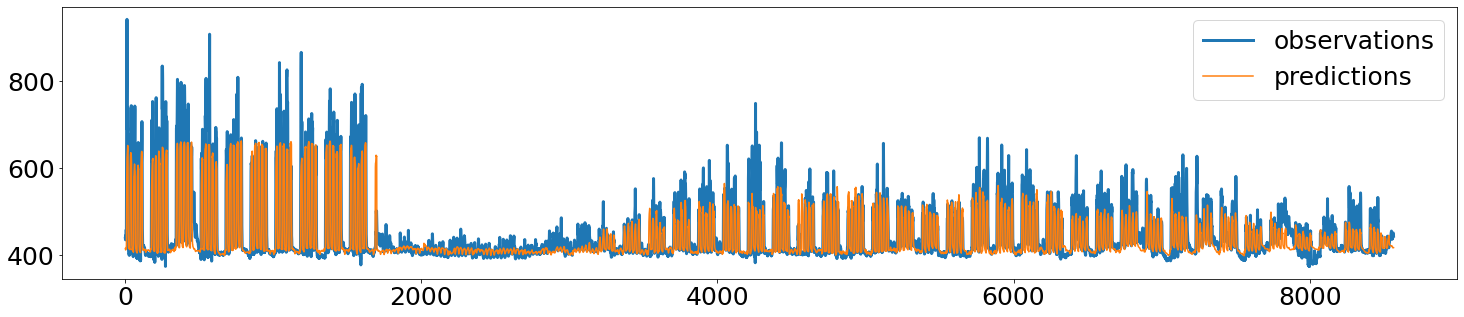

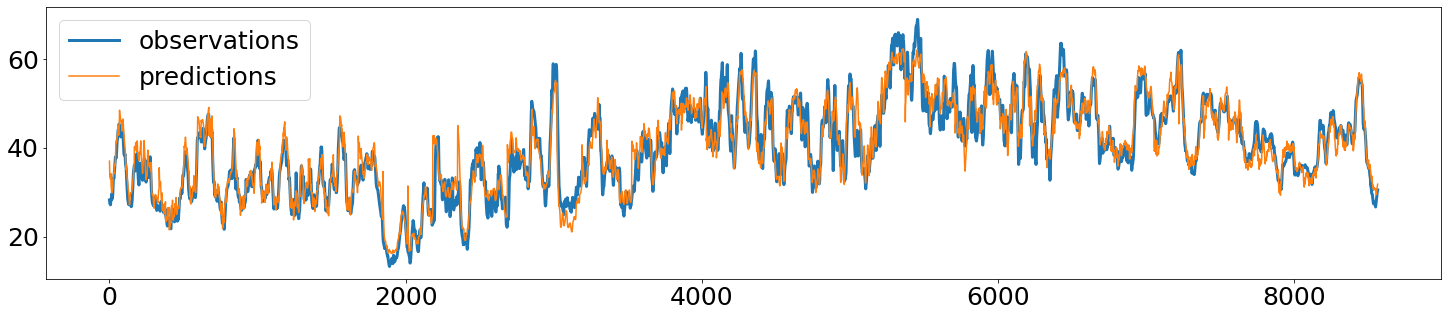

In [10]:
plot_daily_predictions(model, dataloader_train)

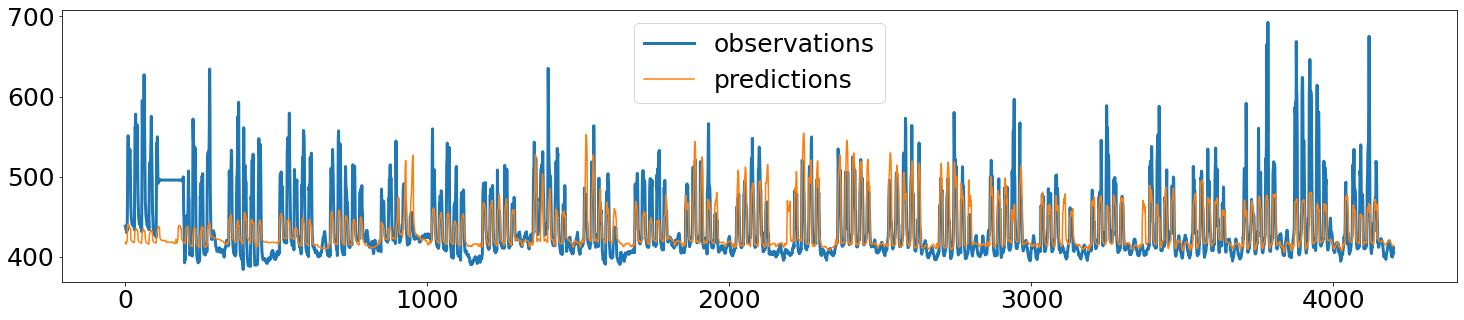

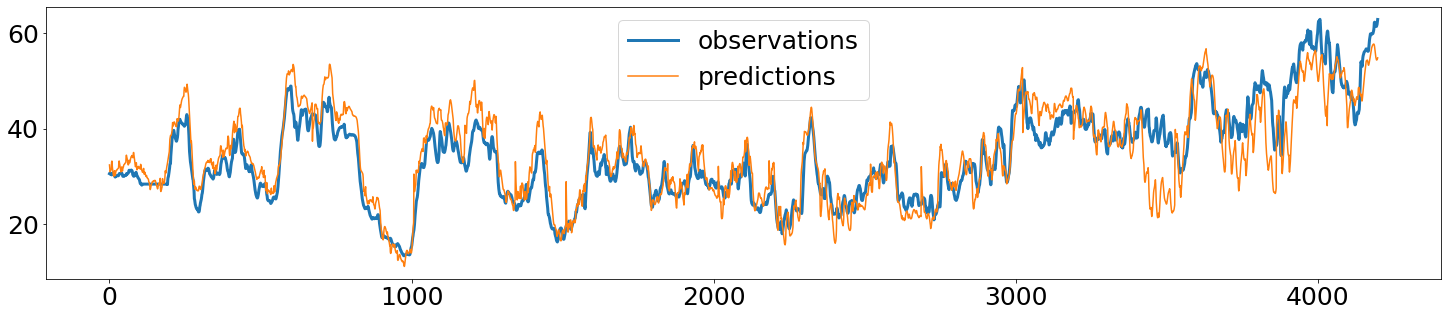

In [11]:
plot_daily_predictions(model, dataloader_val)

## SMC calibration

### Define training steps

In [12]:
class LitSMCModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.MSE = torch.nn.MSELoss()
        
        
        self._SGD_idx = 1
    
    def training_step(self, batch, batch_idx):
        u, y = batch
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)
        # Forward pass
        self.model(u=u, y=y)
        # Compute loss
        loss = self.model.smcl.compute_cost(y=y)
        # Update Sigma_x
        gamma = 1 / np.sqrt(self._SGD_idx)
        self.model.smcl.sigma_x2 = (1 - gamma)*self.model.smcl.sigma_x2 + gamma*self.model.smcl.compute_sigma_x()
        self.model.smcl.sigma_y2 = (1 - gamma)*self.model.smcl.sigma_y2 + gamma*self.model.smcl.compute_sigma_y(y=y)
        self._SGD_idx += 1
        return loss
   
    def configure_optimizers(self):
        # We only optimize SMCL parameters
        optimizer = torch.optim.Adam(self.model.smcl.parameters(), lr=self.lr)
        return optimizer

### Train

In [13]:
# Train model
train_model = LitSMCModule(model, lr=3e-3)
trainer = pl.Trainer(max_epochs=EPOCHS_SMCN, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

# Compute MSE mean and variance
losses = compute_cost(model, dataloader_val)
print(f"MSE:\t{losses.mean():.2f} \pm {losses.var():.4f}")

# Compute PI metrics
picp, mpiw = pi_metrics(model.uncertainty_estimation, dataloader_val)
print(f"PICP:\t{picp.mean():.2f} \pm {picp.var():.4f}\nMPIW:\t{mpiw.mean():.3f} \pm {mpiw.var():.4f}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Epoch: 1/100:   0%|                                                                                                                                                    | 0/100 [00:00<?, ?it/s]
  | Name  | Type    | Params
----------------------------------
0 | model | SMCM    | 1.5 K 
1 | MSE   | MSELoss | 0     
----------------------------------
1.5 K     Trainable params
10        Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
Epoch: 100/100: 100%|██████████████████

MSE:	0.46 \pm 0.1070
PICP:	0.93 \pm 0.0047
MPIW:	1.256 \pm 0.0050


### Evaluate predictions

In [14]:
# Generate inference sample
idx = np.random.randint(0, len(dataloader_val.dataset))
u, y = dataloader_val.dataset[idx]
u = u.unsqueeze(1)
y = y.unsqueeze(1)

# Set target idx for vialization (0 for CO2 levels)
idx_out = 0

#### Traditional inference with new weights

0.46 \pm 0.0224


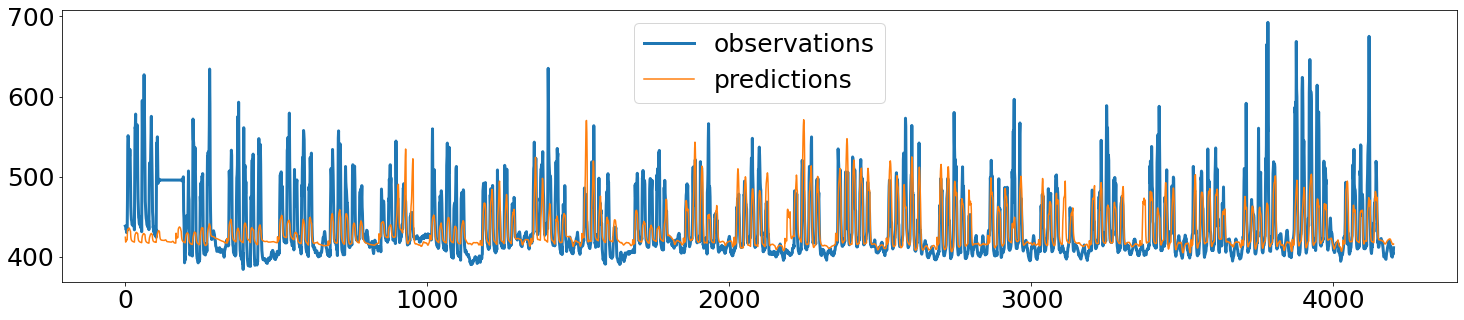

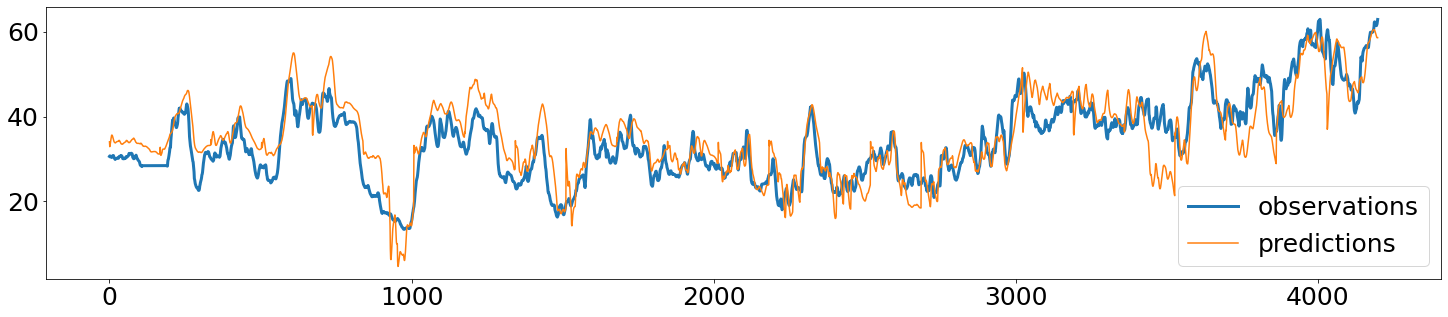

In [15]:
# Plot inference with original model, print cost
model.N=1
plot_daily_predictions(model, dataloader_val)
losses = compute_cost(model, dataloader_val, criteria=torch.nn.L1Loss(reduction='none'))
print(f"{losses.mean():.2f} \pm {losses.var():.4f}")
model.N=N

#### Smoother predictions

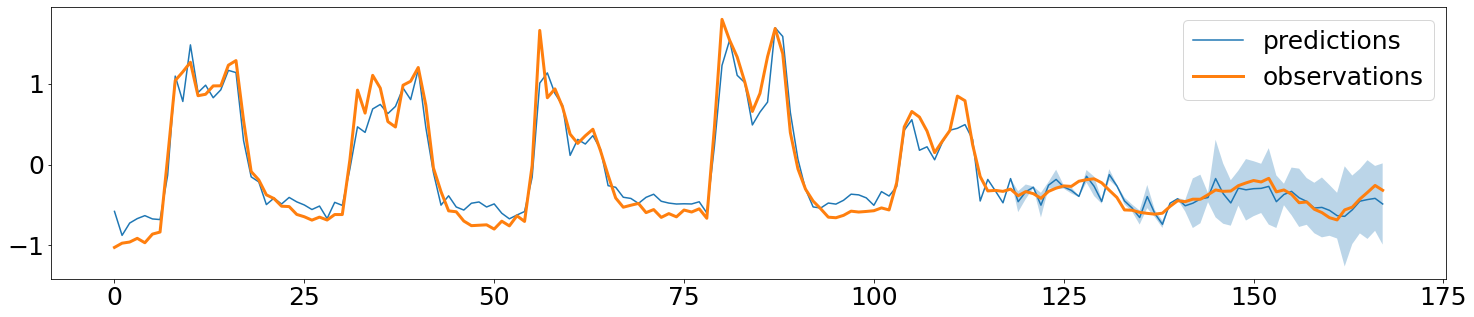

In [16]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I).numpy()

plot_range(netout[:, 0, :, idx_out], label='predictions')
plt.plot(y[:, 0, idx_out], lw=3, label='observations')
plt.legend()
plt.show()

#### Predictions at $t+1$

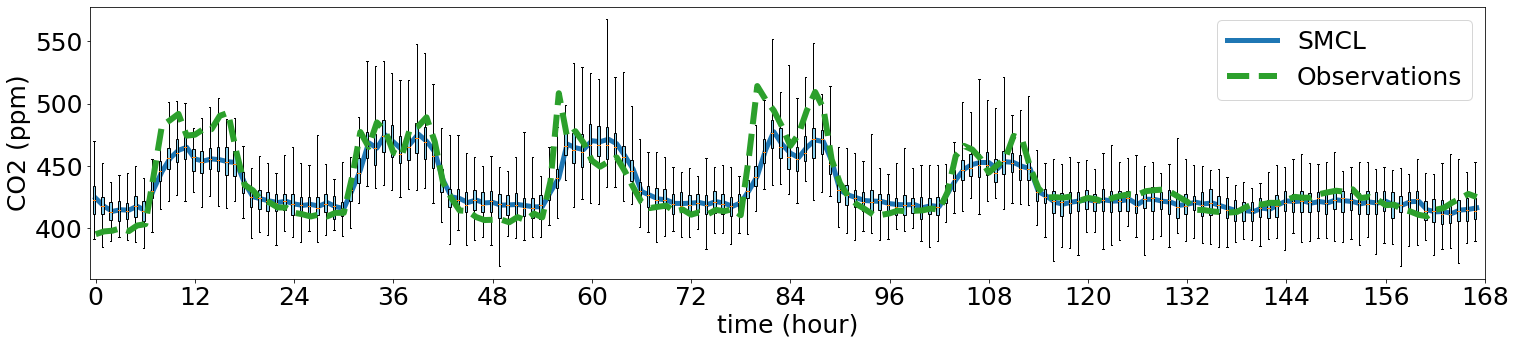

In [17]:
start_day = 0
end_day = start_day+7
day_hide = 0
tick_step = 12
burnin = 0
netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=burnin)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]

plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100, color="#2ca02c")

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

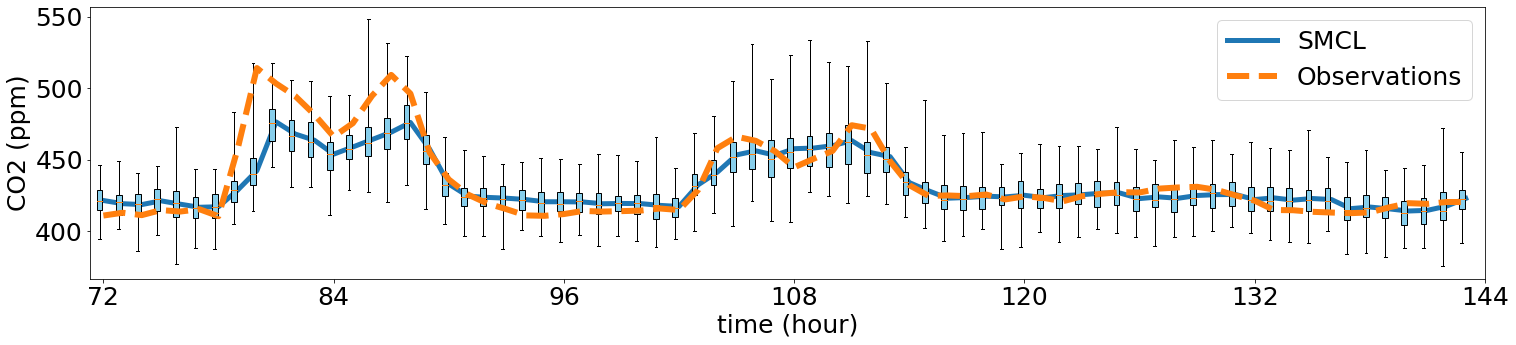

In [18]:
start_day = 3
end_day = start_day+3
day_hide = start_day+1
tick_step = 12

netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=0)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]


plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100)

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

#### Plot particules with $\alpha \propto \omega$

We plot each trajectory, with a transparancy setting proportionnal to their associated weight. This graph aims at visualizing particle degenerecence.

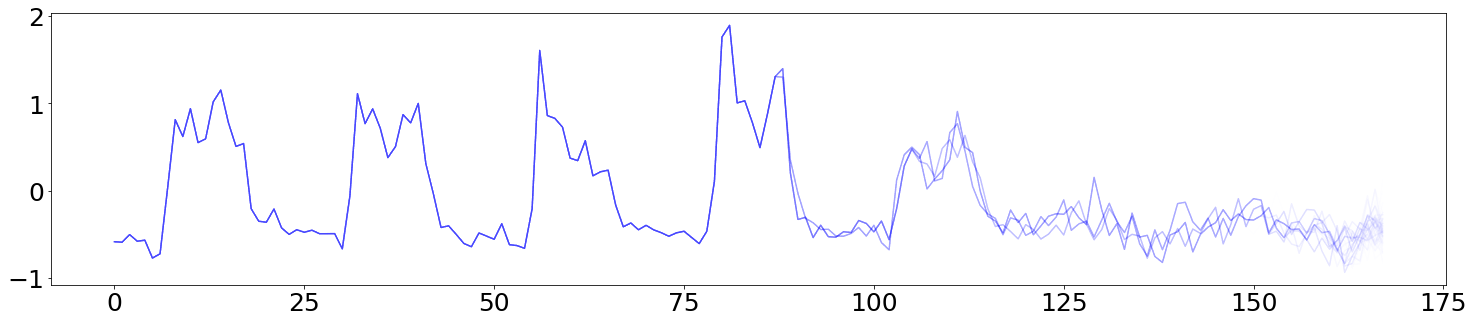

In [19]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I)

batch_idx = 0

netout = netout[:, batch_idx, :, idx_out].numpy()
w = model.smcl.w[batch_idx]
# w = torch.softmax(w, dim=0)
w = w.numpy()

# plt.plot(y[:, batch_idx].squeeze().numpy(), '--', lw=3, alpha=0.6, c='green')
for trajectory, weight in zip(netout.T, w):
    plt.plot(trajectory, alpha=weight, c='blue')